# MFE230T HW4

Jen-Chieh Cheng


# MNIST Digit Recognition

This example uses MNIST dataset of handwritten digits. The dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 1. For simplicity, each image has been flatten and converted to a 1-D numpy array of 784 features (28*28).

## Overview

![MNIST Digits](https://www.tensorflow.org/images/mnist_deep.png)

## What we will accomplish in this example:

- Create a deep convolutional neural network model for recognizing MNIST digits, based on looking at every pixel in the image
- Use Tensorflow to train the model to recognize digits by having it "look" at thousands of examples 
- Check the model's accuracy 


In [1]:
import os
import numpy as np
import tempfile
import tensorflow as tf
import h5py
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import shuffle

plt.style.use('ggplot')
%matplotlib inline

## Build notMNIST class

 1. Use 
``` NotMNIST(BUILD_FROM_H5=False)``` for building data when first time access. Once data created, use ``` NotMNIST(BUILD_FROM_H5=True)``` instead.
 2. The ```reset_batch()``` method is to reset batch counter, so that we can control the training batch in order to compare different optimizer.

In [2]:
class NotMNIST:
    def __init__(self, BUILD_FROM_H5):
        
        if BUILD_FROM_H5:
            h5f = h5py.File('notMNIST.h5','r')
            
            train_images = h5f['train_images'][:]
            train_labels = h5f['train_labels'][:]
            test_images = h5f['test_images'][:]
            test_labels = h5f['test_labels'][:]
        
        else:
            images_l, labels_l = [], []
            for i, letter in enumerate(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']):
                directory = 'notMNIST_large/%s/' % letter
                files = os.listdir(directory)
                label = np.zeros(10)
                label[i] = 1
                for file in files:
                    try:
                        im = Image.open(directory+file)
                    except:
                        print "Skip a corrupted file: " + directory + file
                        continue
                    pixels = np.array(im.convert('L').getdata())
                    images_l.append(pixels/255.0)
                    labels_l.append(label)

            train_images, train_labels = shuffle(images_l, labels_l, random_state=0)
            print 'Transform %d pictures from "notMNIST_large"'%len(train_images)

            images_s, labels_s = [], []
            for i, letter in enumerate(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']):
                directory = 'notMNIST_small/%s/' % letter
                files = os.listdir(directory)
                label = np.zeros(10)
                label[i] = 1
                for file in files:
                    try:
                        im = Image.open(directory+file)
                    except:
                        print "Skip a corrupted file: " + directory + file
                        continue
                    pixels = np.array(im.convert('L').getdata())
                    images_s.append(pixels/255.0)
                    labels_s.append(label)

            test_images, test_labels = shuffle(images_s, labels_s, random_state=1)
            print 'Transform %d pictures from "notMNIST_small"'%len(test_images)
            
            ## Write transformed data
            h5f = h5py.File('notMNIST.h5', 'w')
            h5f.create_dataset('train_images', data = train_images)
            h5f.create_dataset('train_labels', data = train_labels)
            h5f.create_dataset('test_images', data = test_images)
            h5f.create_dataset('test_labels', data = test_labels)
            h5f.close()
        
        class train:
            def __init__(self):
                self.images = []
                self.labels = []
                self.batch_counter = 0
                
            def next_batch(self, num):
                if self.batch_counter + num >= len(self.labels):
                    batch_images = self.images[self.batch_counter:]
                    batch_labels = self.labels[self.batch_counter:]
                    left = num - len(batch_labels)
                    batch_images.extend(self.images[:left])
                    batch_labels.extend(self.labels[:left])
                    self.batch_counter = left
                else:
                    batch_images = self.images[self.batch_counter:self.batch_counter+num]
                    batch_labels = self.labels[self.batch_counter:self.batch_counter+num]                  
                    self.batch_counter += num
                    
                return (batch_images, batch_labels)
            
            def reset_batch(self):
                self.batch_counter = 0
                    
        class test:
            def __init__(self):
                self.images = []
                self.labels = []
                
        self.train = train()
        self.test = test()
                
        self.train.images = train_images
        self.train.labels = train_labels
        self.test.images = test_images
        self.test.labels = test_labels

## Loading the dataset

In [3]:
notMNIST = NotMNIST(BUILD_FROM_H5=True)

print 'Train size: %d'%len(notMNIST.train.images)
print 'Test size: %d'%len(notMNIST.test.images)
print 'Shape of feature:', notMNIST.train.images[0].shape
print 'Shape of label:', notMNIST.train.labels[0].shape

Train size: 529114
Test size: 18724
Shape of feature: (784,)
Shape of label: (10,)


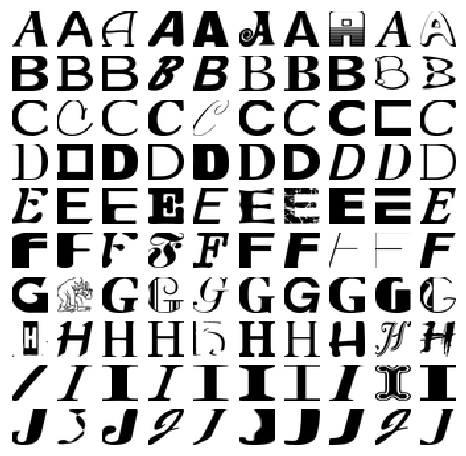

In [4]:
fig = plt.figure(figsize=(8,8))
for i in range(10):
    c = 0
    for (image, label) in zip(notMNIST.test.images, notMNIST.test.labels):
        if np.argmax(label) != i: continue
        subplot = fig.add_subplot(10,10,i*10+c+1)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(image.reshape((28,28)), vmin=0, vmax=1,
                       cmap=plt.cm.gray_r, interpolation="nearest")
        c += 1
        if c == 10: break

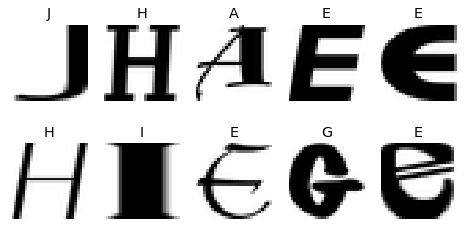

In [5]:
letter = lambda label: 'ABCDEFGHIJ'[np.argmax(label)]

fig = plt.figure(figsize=(8,4))
for c, (image, label) in enumerate(zip(notMNIST.train.images[:10], notMNIST.train.labels[:10])):
    subplot = fig.add_subplot(2,5,c+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%s' % letter(label))
    subplot.imshow(image.reshape((28,28)), vmin=0, vmax=1,
                   cmap=plt.cm.gray_r, interpolation="nearest")

### Weight initialization

In [6]:
def weight_variable(shape):
    """weight_variable generates a weight variable of a given shape."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    """bias_variable generates a bias variable of a given shape."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

### Convolution layers and pooling

In [7]:
def conv2d(x, W):
    """conv2d returns a 2d convolution layer with full stride."""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    """max_pool_2x2 downsamples a feature map by 2X."""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

## Creating the graph structure for the CNN model

In [8]:
import time

def timeit(method):

    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()

        print '%r (%r, %r) %2.2f sec' % \
              (method.__name__, args, kw, te-ts)
        return result

    return timed

In [9]:
@timeit
def notMNIST_model(total_iterations=1000, batch_size = 32, optimizer='Adam', data=notMNIST, v_size=3000):
    
    #### DEFINE CNN Structure ####
    x = tf.placeholder(tf.float32, [None, 784])
    y_ = tf.placeholder(tf.float32, [None, 10])
    
    with tf.name_scope('reshape'):
        x_image = tf.reshape(x, [-1, 28, 28, 1])

    with tf.name_scope('conv1'):
        W_conv1 = weight_variable([5, 5, 1, 32])
        b_conv1 = bias_variable([32])
        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

    with tf.name_scope('pool1'):
        h_pool1 = max_pool_2x2(h_conv1)
        
    with tf.name_scope('conv2'):
        W_conv2 = weight_variable([5, 5, 32, 64])
        b_conv2 = bias_variable([64])
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

    with tf.name_scope('pool2'):
        h_pool2 = max_pool_2x2(h_conv2)
        
    with tf.name_scope('fc1'):
        W_fc1 = weight_variable([7 * 7 * 64, 1024])
        b_fc1 = bias_variable([1024])
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
        
    with tf.name_scope('dropout'):
        keep_prob = tf.placeholder(tf.float32)
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    with tf.name_scope('fc2'):
        W_fc2 = weight_variable([1024, 10])
        b_fc2 = bias_variable([10])
        y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    
    ####
    
    ####
    # COST
    with tf.name_scope('loss'):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv)
    cross_entropy = tf.reduce_mean(cross_entropy)

    # OPTIMIZER
    with tf.name_scope('optimizer'):
        if optimizer == 'Adam':
            train_step = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cross_entropy)
        elif optimizer == 'RMSProp':
            train_step = tf.train.RMSPropOptimizer(learning_rate=1e-3).minimize(cross_entropy)
    
    # ACCURACY
    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
        correct_prediction = tf.cast(correct_prediction, tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)
    ####
    
    ####
    train_acc = []
    val_acc = []
    
    data.train.reset_batch()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(1, total_iterations + 1):
            batch_x, batch_y = data.train.next_batch(batch_size)
            train_step.run(feed_dict={x: batch_x, y_: batch_y, keep_prob: 0.5})
            
            if i % 50 ==0:
                t_acc = accuracy.eval(feed_dict={x: batch_x, y_: batch_y, keep_prob: 1.0})
                v_acc = accuracy.eval(feed_dict={x: data.train.images[-v_size:], y_: data.train.labels[-v_size:], keep_prob: 1.0})
                train_acc.append(t_acc)
                val_acc.append(v_acc)
                
            if i % 200 == 0:
                print('step %d, training accuracy %.4f - validation accuracy %.4f' % (i, t_acc, v_acc))
        
        print('test accuracy %g' % accuracy.eval(feed_dict={x: data.test.images, y_: data.test.labels, keep_prob: 1.0}))
                
    # plot the accuracy
    plt.plot(np.squeeze(train_acc), label='train')
    plt.plot(np.squeeze(val_acc), label='val')
    plt.ylabel('accuracy')
    plt.xlabel('iterations (per 50)')
    plt.title(optimizer + ", Batch Size =" + str(batch_size))
    plt.legend()
    plt.show()

    return train_acc, val_acc

## Train CNN

We have total 529114 training samples in the dataset. For demonstration purpose, we don't use all samples for training; 3000 examples are reserved for validation set. 

We run batch size of 32 and 64 for 5000 iterations, i.e. 160000 and 320000 training sample in total.

step 200, training accuracy 0.8125 - validation accuracy 0.8550
step 400, training accuracy 0.8438 - validation accuracy 0.8680
step 600, training accuracy 0.9688 - validation accuracy 0.8780
step 800, training accuracy 0.9062 - validation accuracy 0.8760
step 1000, training accuracy 0.9375 - validation accuracy 0.8897
step 1200, training accuracy 0.7812 - validation accuracy 0.8943
step 1400, training accuracy 0.9062 - validation accuracy 0.8940
step 1600, training accuracy 0.9375 - validation accuracy 0.8987
step 1800, training accuracy 0.9062 - validation accuracy 0.8967
step 2000, training accuracy 0.8438 - validation accuracy 0.8957
step 2200, training accuracy 0.9062 - validation accuracy 0.8957
step 2400, training accuracy 0.8438 - validation accuracy 0.9010
step 2600, training accuracy 0.9375 - validation accuracy 0.9037
step 2800, training accuracy 0.9688 - validation accuracy 0.9077
step 3000, training accuracy 0.8750 - validation accuracy 0.9047
step 3200, training accuracy 

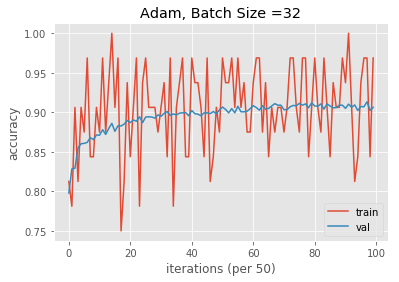

'notMNIST_model' ((), {'optimizer': 'Adam', 'total_iterations': 5000, 'batch_size': 32}) 1193.59 sec


In [10]:
acc_32_adam = notMNIST_model(total_iterations=5000, batch_size=32, optimizer='Adam')

step 200, training accuracy 0.8594 - validation accuracy 0.8647
step 400, training accuracy 0.8594 - validation accuracy 0.8833
step 600, training accuracy 0.8750 - validation accuracy 0.8837
step 800, training accuracy 0.8594 - validation accuracy 0.8960
step 1000, training accuracy 0.9375 - validation accuracy 0.8950
step 1200, training accuracy 0.9062 - validation accuracy 0.8997
step 1400, training accuracy 0.9531 - validation accuracy 0.9077
step 1600, training accuracy 0.8594 - validation accuracy 0.9100
step 1800, training accuracy 0.9062 - validation accuracy 0.9077
step 2000, training accuracy 0.9375 - validation accuracy 0.9103
step 2200, training accuracy 0.9219 - validation accuracy 0.9133
step 2400, training accuracy 0.9375 - validation accuracy 0.9123
step 2600, training accuracy 0.8750 - validation accuracy 0.9117
step 2800, training accuracy 0.8438 - validation accuracy 0.9157
step 3000, training accuracy 0.8750 - validation accuracy 0.9153
step 3200, training accuracy 

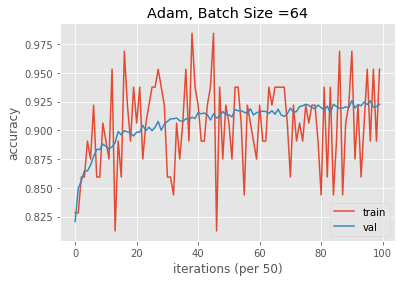

'notMNIST_model' ((), {'optimizer': 'Adam', 'total_iterations': 5000, 'batch_size': 64}) 1777.13 sec


In [11]:
acc_64_adam = notMNIST_model(total_iterations=5000, batch_size=64, optimizer='Adam')

step 200, training accuracy 0.9062 - validation accuracy 0.8193
step 400, training accuracy 0.8750 - validation accuracy 0.8683
step 600, training accuracy 1.0000 - validation accuracy 0.8693
step 800, training accuracy 0.9688 - validation accuracy 0.8857
step 1000, training accuracy 0.9688 - validation accuracy 0.8853
step 1200, training accuracy 0.8750 - validation accuracy 0.8913
step 1400, training accuracy 0.9375 - validation accuracy 0.8830
step 1600, training accuracy 0.9375 - validation accuracy 0.8890
step 1800, training accuracy 0.9688 - validation accuracy 0.8787
step 2000, training accuracy 0.9062 - validation accuracy 0.8870
step 2200, training accuracy 0.9062 - validation accuracy 0.8933
step 2400, training accuracy 0.9688 - validation accuracy 0.8810
step 2600, training accuracy 1.0000 - validation accuracy 0.8937
step 2800, training accuracy 0.9688 - validation accuracy 0.8913
step 3000, training accuracy 0.9062 - validation accuracy 0.8863
step 3200, training accuracy 

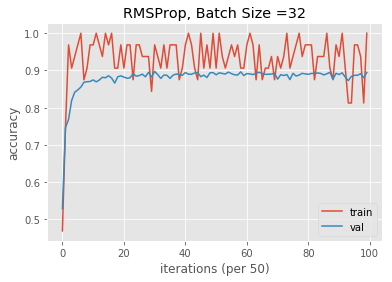

'notMNIST_model' ((), {'optimizer': 'RMSProp', 'total_iterations': 5000, 'batch_size': 32}) 1260.18 sec


In [12]:
acc_32_RMSProp = notMNIST_model(total_iterations=5000, batch_size=32, optimizer='RMSProp')

step 200, training accuracy 0.9062 - validation accuracy 0.8370
step 400, training accuracy 0.9219 - validation accuracy 0.8773
step 600, training accuracy 0.9219 - validation accuracy 0.8893
step 800, training accuracy 0.9062 - validation accuracy 0.8880
step 1000, training accuracy 0.9531 - validation accuracy 0.8997
step 1200, training accuracy 0.9375 - validation accuracy 0.8960
step 1400, training accuracy 0.9688 - validation accuracy 0.8957
step 1600, training accuracy 0.8906 - validation accuracy 0.8947
step 1800, training accuracy 0.9062 - validation accuracy 0.8993
step 2000, training accuracy 0.9688 - validation accuracy 0.8953
step 2200, training accuracy 0.9531 - validation accuracy 0.9030
step 2400, training accuracy 0.9531 - validation accuracy 0.8900
step 2600, training accuracy 0.9219 - validation accuracy 0.8960
step 2800, training accuracy 0.9062 - validation accuracy 0.9010
step 3000, training accuracy 0.9375 - validation accuracy 0.8973
step 3200, training accuracy 

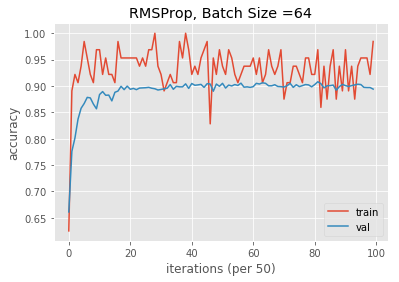

'notMNIST_model' ((), {'optimizer': 'RMSProp', 'total_iterations': 5000, 'batch_size': 64}) 1799.05 sec


In [13]:
acc_64_RMSProp = notMNIST_model(total_iterations=5000, batch_size=64, optimizer='RMSProp')

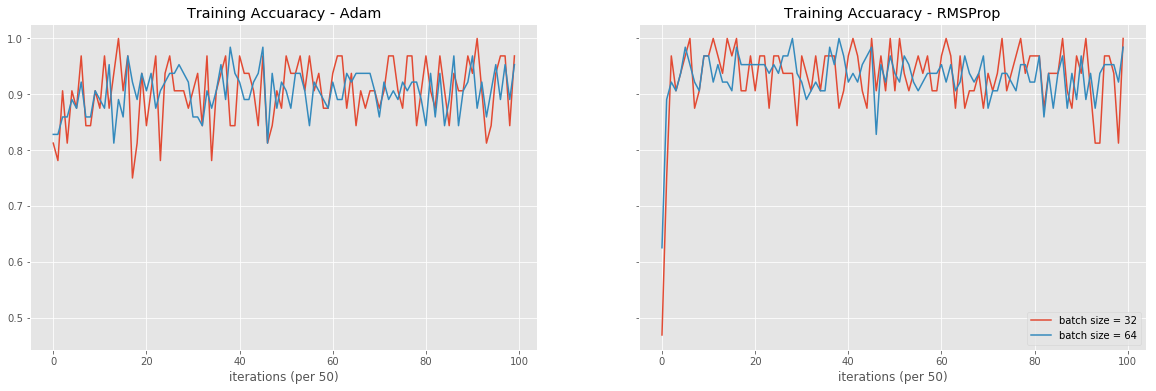

In [18]:
f, ax = plt.subplots(1, 2, sharey=True, figsize=(20,6))
ax[0].plot(acc_32_adam[0], label='batch size = 32')
ax[0].plot(acc_64_adam[0], label='batch size = 64')
ax[0].set_title('Training Accuaracy - Adam')
ax[0].set_xlabel('iterations (per 50)')

ax[1].plot(acc_32_RMSProp[0], label='batch size = 32')
ax[1].plot(acc_64_RMSProp[0], label='batch size = 64')
ax[1].set_title('Training Accuaracy - RMSProp')
ax[1].set_xlabel('iterations (per 50)')
plt.legend()

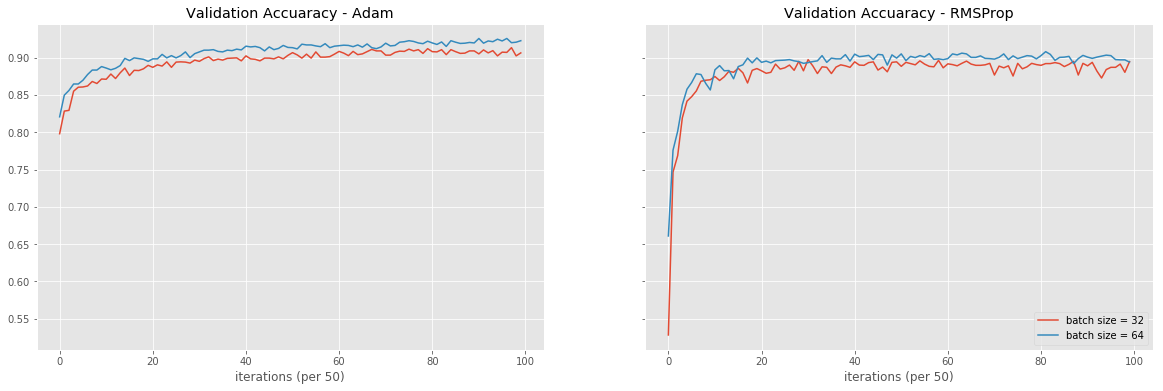

In [19]:
f, ax = plt.subplots(1, 2, sharey=True, figsize=(20,6))
ax[0].plot(acc_32_adam[1], label='batch size = 32')
ax[0].plot(acc_64_adam[1], label='batch size = 64')
ax[0].set_title('Validation Accuaracy - Adam')
ax[0].set_xlabel('iterations (per 50)')

ax[1].plot(acc_32_RMSProp[1], label='batch size = 32')
ax[1].plot(acc_64_RMSProp[1], label='batch size = 64')
ax[1].set_title('Validation Accuaracy - RMSProp')
ax[1].set_xlabel('iterations (per 50)')
plt.legend()

## Result

 - Test Accuracy

| Opimizer  | Adam  | RMSProp  |
|:-:|:-:|:-:|
|  Batch Size = 32 | 0.957167  | 0.942801  |
|  Batch Size = 64 | 0.965766  | 0.950278  |

 - Execution Time (seconds)
 
| Opimizer  | Adam  | RMSProp  |
|:-:|:-:|:-:|
|  Batch Size = 32 | 1193.59  | 1260.18  |
|  Batch Size = 64 | 1777.13  | 1799.05  |

**REMARK:**
 1. All optimizing procedures achieve decent results at early stage (more than 80% validation accuracy at 200th iteration). As we go through the iterations, validation accuracy increases as well.

 2. Increasing batch size will improve the validation/test accuracy at the cost of execution time. Also, larger batch size results in more stable training/validation accuracy when walking through the iterations.

 3. In terms of both test accuracy and execution time, Adam performs better and more efficient than RMSProp, mainly because Adam are less likely to overshoot when gradients are close to zero.

Reference Link: <br />
http://yann.lecun.com/exdb/mnist/ <br />
https://www.tensorflow.org/get_started/mnist/beginners <br />
https://www.tensorflow.org/get_started/mnist/pros <br />
http://enakai00.hatenablog.com/entry/2016/08/02/102917